<a href="https://colab.research.google.com/github/mdsiam135/thesis_2025/blob/main/RF(3_labels).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Starting Random Forest Analysis for Agricultural Production Classification
Loading datasets...
Training data shape: (3942, 84)
Validation data shape: (845, 84)
Test data shape: (845, 84)

Creating production labels based on quantiles...
Quantile thresholds - Low: <1075.000, Medium: 1075.000-4043.770, High: >4043.770

Label distribution:
Training: Production (M.Ton)
Low       1306
Medium    1337
High      1299
Name: count, dtype: int64
Validation: Production (M.Ton)
Low       279
Medium    297
High      269
Name: count, dtype: int64
Test: Production (M.Ton)
Low       275
Medium    279
High      291
Name: count, dtype: int64

Preparing features...
Number of features: 83

Training Random Forest for 10 epochs...
Epoch  1: Train Acc = 0.8947, Val Acc = 0.8497
Epoch  2: Train Acc = 0.9125, Val Acc = 0.8651
Epoch  3: Train Acc = 0.9203, Val Acc = 0.8722
Epoch  4: Train Acc = 0.9226, Val Acc = 0.8769
Epoch  5: Train Acc = 0.9252, Val Acc = 0.8734
Epoch  6: Train Acc = 0.9231, Val Acc = 0.8722


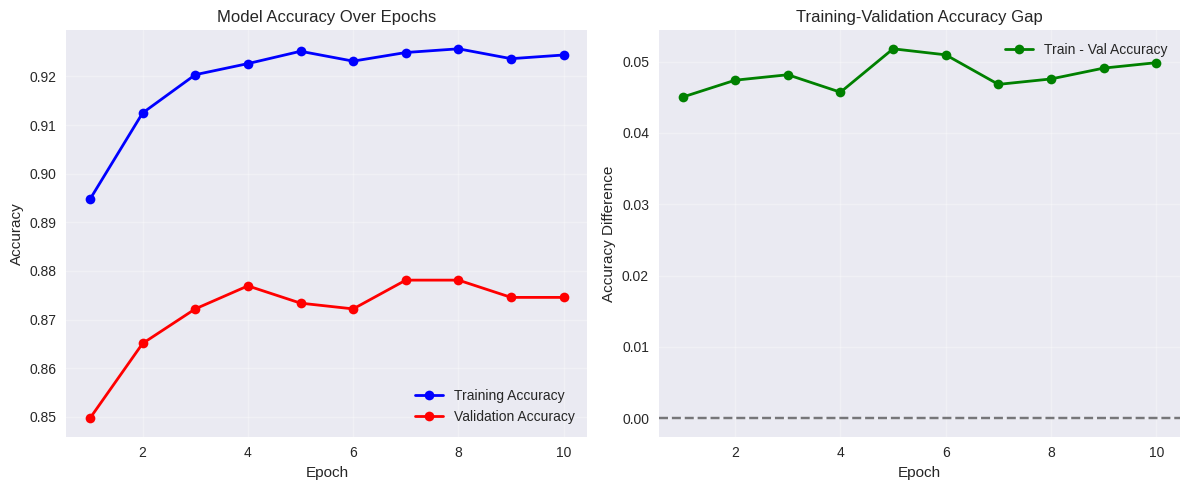


Validation Dataset Evaluation:
Accuracy: 0.8746
Precision (Macro): 0.8743
Recall (Macro): 0.8766
F1-Score (Macro): 0.8751
F1-Score (Weighted): 0.8737

Per-class Metrics:
Low     : Precision=0.9062, Recall=0.9355, F1=0.9206
Medium  : Precision=0.8399, Recall=0.7946, F1=0.8166
High    : Precision=0.8768, Recall=0.8996, F1=0.8881

Detailed Classification Report for Validation:
              precision    recall  f1-score   support

         Low       0.91      0.94      0.92       279
      Medium       0.84      0.79      0.82       297
        High       0.88      0.90      0.89       269

    accuracy                           0.87       845
   macro avg       0.87      0.88      0.88       845
weighted avg       0.87      0.87      0.87       845



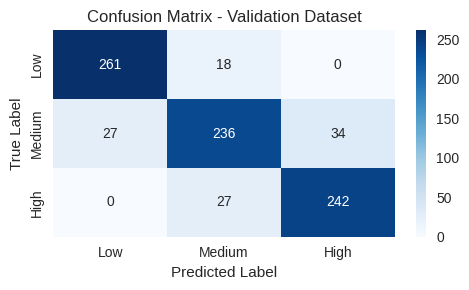


Test Dataset Evaluation:
Accuracy: 0.8627
Precision (Macro): 0.8627
Recall (Macro): 0.8625
F1-Score (Macro): 0.8625
F1-Score (Weighted): 0.8624

Per-class Metrics:
Low     : Precision=0.9265, Recall=0.9164, F1=0.9214
Medium  : Precision=0.8007, Recall=0.7778, F1=0.7891
High    : Precision=0.8609, Recall=0.8935, F1=0.8769

Detailed Classification Report for Test:
              precision    recall  f1-score   support

         Low       0.93      0.92      0.92       275
      Medium       0.80      0.78      0.79       279
        High       0.86      0.89      0.88       291

    accuracy                           0.86       845
   macro avg       0.86      0.86      0.86       845
weighted avg       0.86      0.86      0.86       845



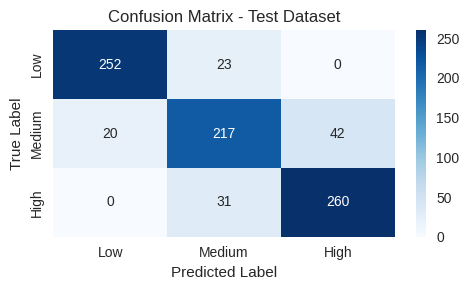


Feature Importance Analysis:


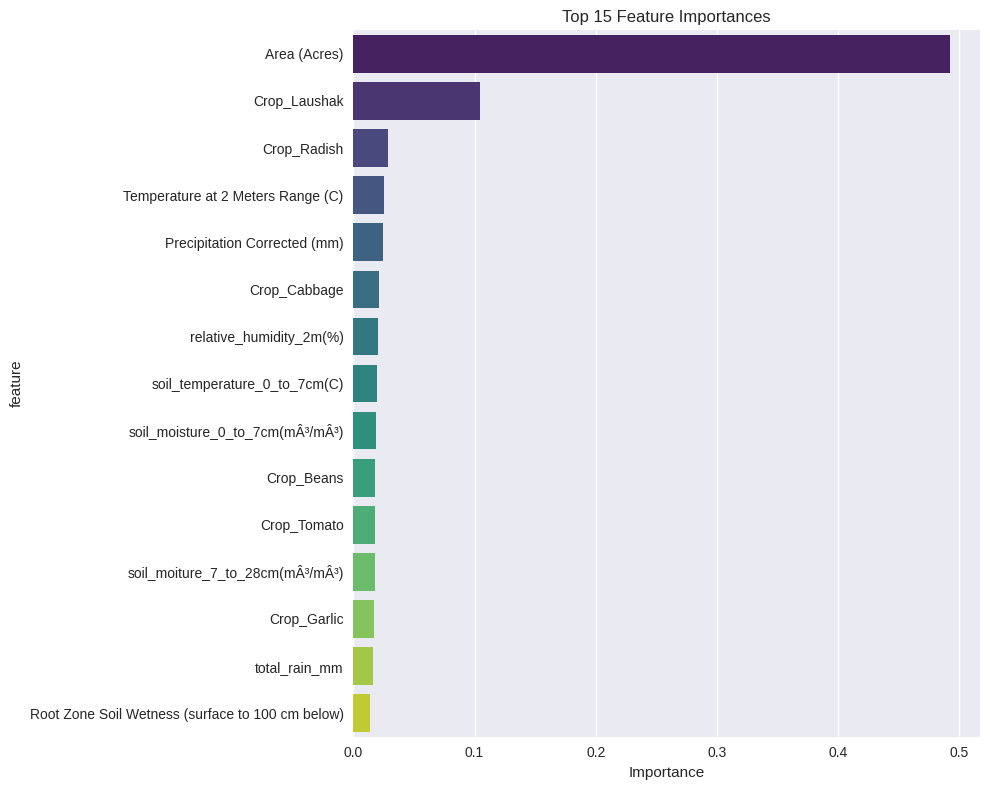


Final Summary:
Validation Macro F1-Score: 0.8751
Test Macro F1-Score: 0.8625
Validation Accuracy: 0.8746
Test Accuracy: 0.8627

Analysis Complete!
Check the plots above for:
1. Training vs Validation Accuracy over epochs
2. Confusion matrices for validation and test sets
3. Feature importance rankings


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                           accuracy_score, precision_score, recall_score,
                           f1_score, precision_recall_fscore_support)
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class RandomForestProductionClassifier:
    def __init__(self, n_estimators=100, random_state=42):
        self.rf_model = RandomForestClassifier(
            n_estimators=n_estimators,
            random_state=random_state,
            n_jobs=-1
        )
        self.scaler = StandardScaler()
        self.feature_names = None
        self.class_labels = ['Low', 'Medium', 'High']
        self.train_scores = []
        self.val_scores = []

    def load_data(self, train_path, val_path, test_path):
        """Load the three CSV files"""
        print("Loading datasets...")
        self.train_df = pd.read_csv(train_path)
        self.val_df = pd.read_csv(val_path)
        self.test_df = pd.read_csv(test_path)

        print(f"Training data shape: {self.train_df.shape}")
        print(f"Validation data shape: {self.val_df.shape}")
        print(f"Test data shape: {self.test_df.shape}")

    def create_production_labels(self):
        """Create quantile-based labels for production"""
        print("\nCreating production labels based on quantiles...")

        # Combine all production data to calculate consistent quantiles
        all_production = pd.concat([
            self.train_df['Production (M.Ton)'],
            self.val_df['Production (M.Ton)'],
            self.test_df['Production (M.Ton)']
        ])

        # Calculate quantiles
        q1 = all_production.quantile(0.33)
        q2 = all_production.quantile(0.67)

        print(f"Quantile thresholds - Low: <{q1:.3f}, Medium: {q1:.3f}-{q2:.3f}, High: >{q2:.3f}")

        # Create labels for each dataset
        def create_labels(production_series):
            labels = pd.cut(production_series,
                          bins=[-np.inf, q1, q2, np.inf],
                          labels=['Low', 'Medium', 'High'])
            return labels

        self.train_labels = create_labels(self.train_df['Production (M.Ton)'])
        self.val_labels = create_labels(self.val_df['Production (M.Ton)'])
        self.test_labels = create_labels(self.test_df['Production (M.Ton)'])

        # Print label distribution
        print("\nLabel distribution:")
        print("Training:", self.train_labels.value_counts().sort_index())
        print("Validation:", self.val_labels.value_counts().sort_index())
        print("Test:", self.test_labels.value_counts().sort_index())

    def prepare_features(self):
        """Prepare feature matrices"""
        print("\nPreparing features...")

        # Drop the target column
        feature_cols = [col for col in self.train_df.columns if col != 'Production (M.Ton)']

        self.X_train = self.train_df[feature_cols]
        self.X_val = self.val_df[feature_cols]
        self.X_test = self.test_df[feature_cols]

        self.feature_names = feature_cols

        # Handle missing values if any
        self.X_train = self.X_train.fillna(self.X_train.mean())
        self.X_val = self.X_val.fillna(self.X_train.mean())
        self.X_test = self.X_test.fillna(self.X_train.mean())

        print(f"Number of features: {len(feature_cols)}")

    def train_with_epochs(self, epochs=10):
        """Train Random Forest with incremental n_estimators (simulating epochs)"""
        print(f"\nTraining Random Forest for {epochs} epochs...")

        self.train_scores = []
        self.val_scores = []

        # Convert labels to numeric for training
        y_train_numeric = pd.Categorical(self.train_labels).codes
        y_val_numeric = pd.Categorical(self.val_labels).codes

        for epoch in range(1, epochs + 1):
            # Increase n_estimators with each epoch
            n_trees = epoch * 10

            # Create and train model
            rf_temp = RandomForestClassifier(
                n_estimators=n_trees,
               max_depth=15,
               min_samples_split=10,
               min_samples_leaf=5,
               max_features='sqrt',
               random_state=42,
               n_jobs=-1
            )


            rf_temp.fit(self.X_train, y_train_numeric)

            # Calculate accuracies
            train_pred = rf_temp.predict(self.X_train)
            val_pred = rf_temp.predict(self.X_val)

            train_acc = accuracy_score(y_train_numeric, train_pred)
            val_acc = accuracy_score(y_val_numeric, val_pred)

            self.train_scores.append(train_acc)
            self.val_scores.append(val_acc)

            print(f"Epoch {epoch:2d}: Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")

        # Final model with best n_estimators
        self.rf_model = RandomForestClassifier(
            n_estimators=epochs * 10,
            random_state=42,
            n_jobs=-1
        )
        self.rf_model = RandomForestClassifier(
           n_estimators=epochs * 10,
           max_depth=15,
           min_samples_split=10,
          min_samples_leaf=5,
          max_features='sqrt',
          random_state=42,
          n_jobs=-1
        )

        self.rf_model.fit(self.X_train, y_train_numeric)

    def evaluate_model(self, X, y_true, dataset_name):
        """Evaluate model and return metrics"""
        y_true_numeric = pd.Categorical(y_true).codes
        y_pred_numeric = self.rf_model.predict(X)

        # Calculate metrics
        accuracy = accuracy_score(y_true_numeric, y_pred_numeric)
        precision_macro = precision_score(y_true_numeric, y_pred_numeric, average='macro')
        recall_macro = recall_score(y_true_numeric, y_pred_numeric, average='macro')
        f1_macro = f1_score(y_true_numeric, y_pred_numeric, average='macro')
        f1_weighted = f1_score(y_true_numeric, y_pred_numeric, average='weighted')

        # Per-class metrics
        precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(
            y_true_numeric, y_pred_numeric, average=None
        )

        print(f"\n{dataset_name} Dataset Evaluation:")
        print("="*50)
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision (Macro): {precision_macro:.4f}")
        print(f"Recall (Macro): {recall_macro:.4f}")
        print(f"F1-Score (Macro): {f1_macro:.4f}")
        print(f"F1-Score (Weighted): {f1_weighted:.4f}")

        print("\nPer-class Metrics:")
        for i, class_name in enumerate(self.class_labels):
            print(f"{class_name:8s}: Precision={precision_per_class[i]:.4f}, "
                  f"Recall={recall_per_class[i]:.4f}, F1={f1_per_class[i]:.4f}")

        # Classification report
        print(f"\nDetailed Classification Report for {dataset_name}:")
        print(classification_report(y_true_numeric, y_pred_numeric,
                                  target_names=self.class_labels))

        return {
            'accuracy': accuracy,
            'precision_macro': precision_macro,
            'recall_macro': recall_macro,
            'f1_macro': f1_macro,
            'f1_weighted': f1_weighted,
            'y_pred': y_pred_numeric,
            'y_true': y_true_numeric
        }

    def plot_confusion_matrix(self, y_true, y_pred, dataset_name):
        """Plot confusion matrix"""
        cm = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(5, 3))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=self.class_labels,
                   yticklabels=self.class_labels)
        plt.title(f'Confusion Matrix - {dataset_name} Dataset')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.tight_layout()
        plt.show()

    def plot_training_history(self):
        """Plot training and validation accuracy over epochs"""
        plt.figure(figsize=(12, 5))

        # Training vs Validation Accuracy
        plt.subplot(1, 2, 1)
        epochs = range(1, len(self.train_scores) + 1)
        plt.plot(epochs, self.train_scores, 'bo-', label='Training Accuracy', linewidth=2)
        plt.plot(epochs, self.val_scores, 'ro-', label='Validation Accuracy', linewidth=2)
        plt.title('Model Accuracy Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Difference between train and validation
        plt.subplot(1, 2, 2)
        diff = np.array(self.train_scores) - np.array(self.val_scores)
        plt.plot(epochs, diff, 'go-', label='Train - Val Accuracy', linewidth=2)
        plt.title('Training-Validation Accuracy Gap')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy Difference')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)

        plt.tight_layout()
        plt.show()

    def plot_feature_importance(self, top_n=15):
        """Plot feature importance"""
        importance_df = pd.DataFrame({
            'feature': self.feature_names,
            'importance': self.rf_model.feature_importances_
        }).sort_values('importance', ascending=False)

        plt.figure(figsize=(10, 8))
        sns.barplot(data=importance_df.head(top_n),
                   x='importance', y='feature', palette='viridis')
        plt.title(f'Top {top_n} Feature Importances')
        plt.xlabel('Importance')
        plt.tight_layout()
        plt.show()

        return importance_df

    def run_complete_analysis(self, train_path, val_path, test_path, epochs=10):
        """Run the complete analysis pipeline"""
        print("Starting Random Forest Analysis for Agricultural Production Classification")
        print("="*80)

        # Load data
        self.load_data(train_path, val_path, test_path)

        # Create labels
        self.create_production_labels()

        # Prepare features
        self.prepare_features()

        # Train model
        self.train_with_epochs(epochs)

        # Plot training history
        self.plot_training_history()

        # Evaluate on validation set
        val_metrics = self.evaluate_model(self.X_val, self.val_labels, "Validation")
        self.plot_confusion_matrix(val_metrics['y_true'], val_metrics['y_pred'], "Validation")

        # Evaluate on test set
        test_metrics = self.evaluate_model(self.X_test, self.test_labels, "Test")
        self.plot_confusion_matrix(test_metrics['y_true'], test_metrics['y_pred'], "Test")

        # Feature importance
        print("\nFeature Importance Analysis:")
        print("="*50)
        importance_df = self.plot_feature_importance()

        # Summary
        print("\nFinal Summary:")
        print("="*50)
        print(f"Validation Macro F1-Score: {val_metrics['f1_macro']:.4f}")
        print(f"Test Macro F1-Score: {test_metrics['f1_macro']:.4f}")
        print(f"Validation Accuracy: {val_metrics['accuracy']:.4f}")
        print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")

        return {
            'model': self.rf_model,
            'validation_metrics': val_metrics,
            'test_metrics': test_metrics,
            'feature_importance': importance_df
        }

# Usage Example
if __name__ == "__main__":
    # Initialize the classifier
    rf_classifier = RandomForestProductionClassifier(random_state=42)

    # Run complete analysis
    results = rf_classifier.run_complete_analysis(
        train_path='/content/drive/MyDrive/UpdatedDataset/train.csv',
        val_path='/content/drive/MyDrive/UpdatedDataset/validation.csv',
        test_path='/content/drive/MyDrive/UpdatedDataset/test.csv',
        epochs=10
    )

    print("\nAnalysis Complete!")
    print("Check the plots above for:")
    print("1. Training vs Validation Accuracy over epochs")
    print("2. Confusion matrices for validation and test sets")
    print("3. Feature importance rankings")